In [227]:
# Import Statements
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import CenterCrop
import matplotlib.pyplot as plt
import numpy as np

In [228]:
# Lets define some parameters
IMAGE_FOLDER = '../TestData'
IMAGE_SIZE = 444
TARGET_SIZE = 260
MASK_RADIUS = 120
TEST_SPLIT = .15
VALIDATION_SPLIT = .15
BATCH_SIZE = 8
EPOCHS = 1000
LEARNING_RATE = 5e-6

In [229]:
# Lets write our custom datasets, dataloaders and related functions first
class FermiUNDataset(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.image_list = os.listdir(image_dir)
        self.transform = transform
        self.target_transform = target_transform

        # Make the mask for our images
        _scale = np.arange(IMAGE_SIZE)
        _mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        _mask[(_scale[np.newaxis, :] - (IMAGE_SIZE - 1) / 2) ** 2
             + (_scale[:, np.newaxis] - (IMAGE_SIZE - 1) / 2) ** 2
             > MASK_RADIUS ** 2] = 1
        self.mask = torch.from_numpy(_mask)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        _image_path = os.path.join(self.image_dir, self.image_list[index])
        _image = np.load(_image_path)
        _image = _image[np.newaxis, ...]
        _image = torch.from_numpy(_image)
        _masked = _image * self.mask
        _target = CenterCrop([TARGET_SIZE, TARGET_SIZE])(_image)
        if self.transform:
            _masked = self.transform(_masked)
        if self.target_transform:
            _target = self.target_transform(_target)
        return _masked, _target

FermiUNData = FermiUNDataset(IMAGE_FOLDER)

# Split into training, validation, test
dataset_size = len(FermiUNData)
dataset_indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(dataset_indices)
first_split, second_split = int(np.floor(VALIDATION_SPLIT*dataset_size)), \
                            dataset_size-int(np.floor(TEST_SPLIT*dataset_size))
validation_indices, train_indices, test_indices = dataset_indices[:first_split], \
                                                  dataset_indices[first_split:second_split], \
                                                  dataset_indices[second_split:]

FermiUNLoaderTraining = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                   sampler=SubsetRandomSampler(train_indices))
FermiUNLoaderValidation = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                     sampler=SubsetRandomSampler(validation_indices))
FermiUNLoaderTesting = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                  sampler=SubsetRandomSampler(test_indices))

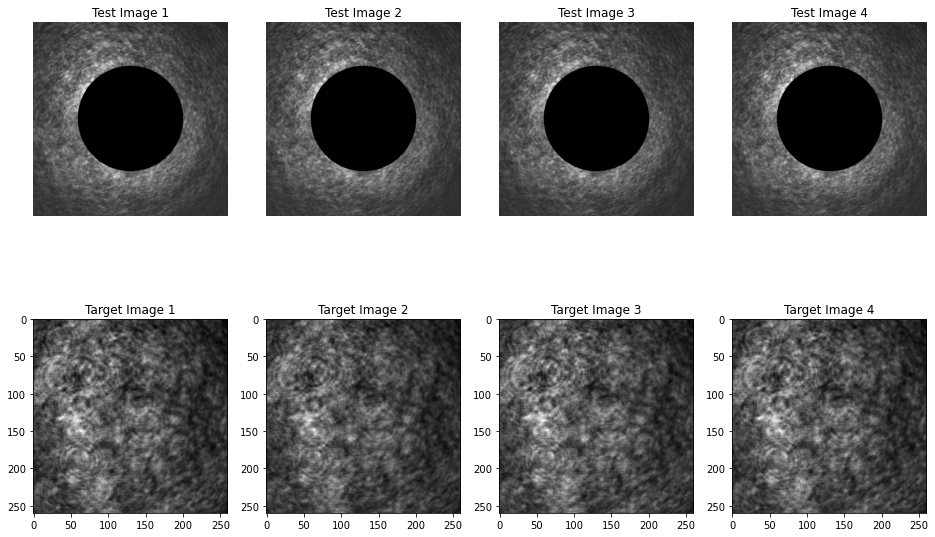

In [230]:
# Test our Dataloader
figure = plt.figure(figsize=(16,10))
test_image,target_image = next(iter(FermiUNLoaderTesting))
for i in range(1,5):
    figure.add_subplot(2,4,i)
    plt.title(f'Test Image {i}')
    plt.axis('off')
    plt.imshow(test_image[i,0,:,:], cmap="gray")
    figure.add_subplot(2,4,i+4)
    plt.title(f'Target Image {i}')#    plt.axis('off')
    plt.imshow(target_image[i,0,:,:], cmap="gray")
plt.show()

In [231]:
# Do we have a gpu?
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device!")

Using cpu device!


In [232]:
# Lets define our model
class EncoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, channels=(1, 16, 32, 64, 128, 256)):
        super().__init__()
        self.EncoderBlocks = nn.ModuleList(
            [EncoderBlock(channels[i], channels[i+1])
             for i in range(len(channels)-1)])
        self.MaxPool = nn.MaxPool2d(2)

    def forward(self, x):
        outputs = []
        for block in self.EncoderBlocks:
            x = block(x)
            outputs.append(x)
            x = self.MaxPool(x)
        return outputs

class Decoder(nn.Module):
    def __init__(self, channels=(256, 128, 64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.UpConvolutions = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2)
             for i in range(len(channels)-1)])
        self.DecoderBlocks = nn.ModuleList(
            [EncoderBlock(channels[i], channels[i+1])
             for i in range(len(channels)-1)])

    def crop(self, encoder_features, x):
        # crop the encoder features to match the current dimensions
        _,_,height,width = x.shape
        encoder_features = CenterCrop([height, width])(encoder_features)
        return encoder_features

    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.UpConvolutions[i](x)
            cropped_feature = self.crop(encoder_features[i], x)
            x = torch.cat([x, cropped_feature], dim=1)
            x = self.DecoderBlocks[i](x)
        return x

class Unet(nn.Module):
    def __init__(self, encoder_channels=(1, 16, 32, 64, 128, 256), decoder_channels=(256, 128, 64, 32, 16)):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)
        self.head = nn.Conv2d(decoder_channels[-1], 1, 1)

    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
        out = self.head(decoder_features)
        return out

model = Unet().to(device)
print(model)

Unet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Encoder(
    (EncoderBlocks): ModuleList(
      (0): EncoderBlock(
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): EncoderBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): EncoderBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): EncoderBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): EncoderBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2

In [233]:
# Test the encoder and decoder definitions
encoder = Encoder()#
x = torch.randn(1, 1, 444, 444)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

decoder = Decoder()
x = decoder(ftrs[::-1][0], ftrs[::-1][1:])
y = nn.Conv2d(16, 1, 1)(x)
y.shape

#unet = Unet()
#for batch, (X,y) in enumerate(FermiUNLoaderTraining):
#    print(f"{unet(X.float()).shape}")
#    break

torch.Size([1, 16, 440, 440])
torch.Size([1, 32, 216, 216])
torch.Size([1, 64, 104, 104])
torch.Size([1, 128, 48, 48])
torch.Size([1, 256, 20, 20])


torch.Size([1, 1, 260, 260])

In [234]:
# Training Loops
def training_loop(dataloader, model, loss_function, optimizer):
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.float().to(device),y.float().to(device)
        prediction = model(X)
        loss = loss_function(prediction,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100 == 0:
            loss,current = loss.item(), batch*len(X)
            print(f"Loss: {loss:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]")

def no_inference_loop(dataloader, model, loss_function):
    num_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.float().to(device),y.float().to(device)
            prediction = model(X)
            loss += loss_function(prediction,y).item()
        loss /= num_batches
    return loss

def test_loop(dataloader, model, loss_function):
    loss = no_inference_loop(dataloader, model, loss_function)
    print(f"Average loss in test dataset: {loss:>8f}")

def validation_loop(dataloader, model, loss_function):
    loss = no_inference_loop(dataloader, model, loss_function)
    print(f"Validation loss: {loss:>7f}")

In [235]:
# Train the network
torch.cuda.empty_cache()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n--------------------------")
    training_loop(FermiUNLoaderTraining, model, loss_function, optimizer)
    validation_loop(FermiUNLoaderValidation, model, loss_function)
test_loop(FermiUNLoaderTesting, model, loss_function)
print("Training complete.\n")

Epoch 1
--------------------------
Loss: 0.212873 [    0/  201]
Validation loss: 0.211495
Epoch 2
--------------------------
Loss: 0.211220 [    0/  201]
Validation loss: 0.209740
Epoch 3
--------------------------
Loss: 0.209206 [    0/  201]
Validation loss: 0.207975
Epoch 4
--------------------------
Loss: 0.207481 [    0/  201]
Validation loss: 0.206044
Epoch 5
--------------------------
Loss: 0.205573 [    0/  201]
Validation loss: 0.204142
Epoch 6
--------------------------
Loss: 0.203485 [    0/  201]
Validation loss: 0.202109
Epoch 7
--------------------------
Loss: 0.202121 [    0/  201]
Validation loss: 0.200053
Epoch 8
--------------------------
Loss: 0.199827 [    0/  201]
Validation loss: 0.197944
Epoch 9
--------------------------
Loss: 0.198094 [    0/  201]
Validation loss: 0.195686
Epoch 10
--------------------------
Loss: 0.195054 [    0/  201]
Validation loss: 0.193375
Epoch 11
--------------------------
Loss: 0.192859 [    0/  201]
Validation loss: 0.191059
Epoch 12

KeyboardInterrupt: 